In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Funkcje pomocnicze

In [2]:
def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

### Funkcje aktywacji

In [3]:
def relu(batch):
    return np.maximum(0.0, batch)

def relu_derivative(batch):
    
    return (batch>0).astype(np.float32)
    

def softmax(batch):    
    
    expBatch = np.exp(batch)
    sumRow = np.sum(expBatch, axis = 1)    
    return expBatch/as_matrix(sumRow)
    


# Zbiór danych MNIST

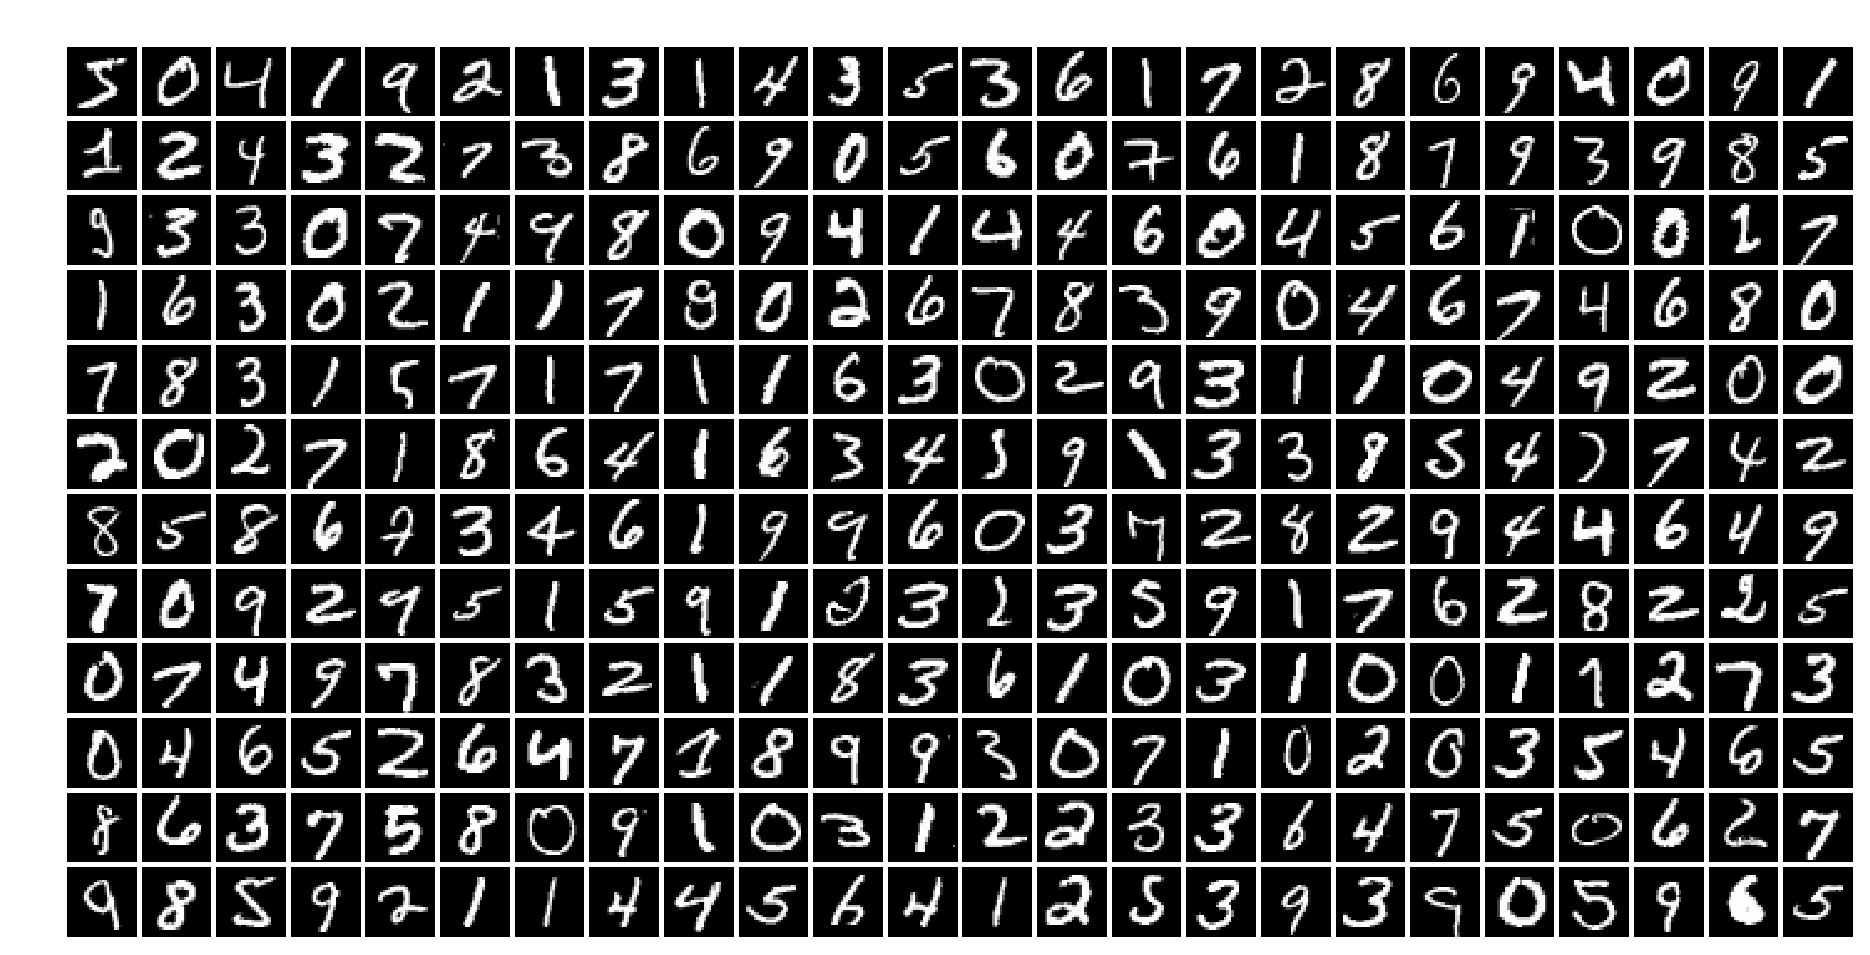

In [4]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Warstwy sieci neuronowej

Budujemy sieci złożone z dwóch rodzajów warstwy: warstwy w pełni połączonej (```Dense```) i warstwy, które wylicza nieliniową funkcję aktywacji (```Nonlinear```). Obie warstwy implementują dwie funkcje

- propagacja sygnału: ```forward```
- wsteczna propagacja błędu: ```backward```

Operacja ```backward``` propaguje gradient funkcji kosztu do poprzedniej warstwy. Dodatkowo, w przypadku warstwy w pełni połączonej wylicza pochodne funkcji kosztu po wagach i składowej stałej.

### Warstwa nieliniowej funkcji aktywacji

In [5]:
class Nonlinear:
    def __init__(self, activation_fun, d_activation_fun):
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
        
        self.visible = None
    
    def reset(self):
        pass
    
    def forward(self, batch):
        self.visible = batch
        return self.activation_fun(batch)
    
    def backward(self, grad):
        return grad*self.d_activation_fun(self.visible)
    
    

### Warstwa w pełni połączona

In [6]:
class Dense:
    def __init__(self, visible_size, hidden_size, learning_rate, momentum):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=np.sqrt(2.0 / self.visible_size),
                                  size=(self.visible_size, self.hidden_size)).astype(np.float32)
        self.B = zeros(1, self.hidden_size)
        
        self.visible = None

        self.MW = zeros(self.visible_size, self.hidden_size)
        self.MB = zeros(1, self.hidden_size)
    
    def forward(self, batch):
        self.visible = batch            
        return (batch @ self.W) + self.B
    
    def backward(self, grad):
        observations_count = self.visible.shape[0]
        
        prev_grad = grad @ self.W.T
        
        grad_w = self.visible.T @ grad / observations_count
        grad_b = np.sum(grad, axis=0) / observations_count
        
        self.W -= self.learning_rate * grad_w
        self.B -= self.learning_rate * grad_b
        
        return prev_grad

# Wsteczna propagacja błędu

In [7]:
def forward_pass(mlp, batch):
    for layer in mlp:
        batch = layer.forward(batch)
        
    return batch

In [8]:
def error_backpropagate(mlp, grad):
    for layer in reversed(mlp):
        grad = layer.backward(grad)

### Training sieci neuronowej

In [9]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] // batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):

        y = forward_pass(mlp, batch)
        
        grad = y - batch_labels
        error_backpropagate(mlp[0:-1], grad)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

# Klasyfikacja cyfr MNIST

In [10]:
def classify(mlp, batch):
    probabilities = np.concatenate([forward_pass(mlp, mini_batch) for mini_batch in chunks(batch, 128)])
    return np.argmax(probabilities, axis=1)

def run_training(mlp, train_set, train_labels,
                 validation_set, validation_labels,
                 batch_size, epochs_count):
    
    for epoch in range(epochs_count):
        print("Epoka {}:".format(epoch+1),  end="\t")

        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.9
                
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\tczas: {0:>2.2f}s, dokładność: {1:>2.2f}".format(elapsed, accuracy))

    print("Trening zakończony!")

In [11]:
import time

DATASET_SIZE = 10000 # 60000 dla całego zbioru danych
DIGIT_SIZE = 28

##### Zbiór uczący #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Zbiór testowy #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)

mnist_test_labels = mnist.test_labels()

In [13]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.01
MOMENTUM = 0.5

mlp = [
    Dense(
        visible_size = 28 * 28,
        hidden_size = 256,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    #Nonlinear(relu, relu_derivative),
    Dense(
        visible_size = 256,
        hidden_size = 256,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    #Nonlinear(relu, relu_derivative),
    Dense(
        visible_size = 256,
        hidden_size = 256,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    #Nonlinear(relu, relu_derivative),
    Dense(
        visible_size = 256,
        hidden_size = 10,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(softmax, None)
]

run_training(mlp,
             mnist_train_images, mnist_train_labels,
             mnist_test_images, mnist_test_labels,
             BATCH_SIZE, EPOCHS_COUNT)

Epoka 1:	########################################	czas: 3.13s, dokładność: 81.68
Epoka 2:	########################################	czas: 2.70s, dokładność: 85.69
Epoka 3:	########################################	czas: 2.47s, dokładność: 87.40
Epoka 4:	########################################	czas: 2.19s, dokładność: 88.26
Epoka 5:	########################################	czas: 1.96s, dokładność: 88.89
Epoka 6:	########################################	czas: 1.76s, dokładność: 89.21
Epoka 7:	########################################	czas: 1.41s, dokładność: 89.44
Epoka 8:	########################################	czas: 1.33s, dokładność: 89.65
Epoka 9:	########################################	czas: 1.24s, dokładność: 89.78
Epoka 10:	########################################	czas: 1.54s, dokładność: 89.90
Epoka 11:	########################################	czas: 2.40s, dokładność: 90.05
Epoka 12:	########################################	czas: 1.60s, dokładność: 90.23
Epoka 13:	###############